In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import astropy.units as u
from astropy.constants import c
from scipy import stats
from scipy.optimize import minimize
from itertools import product
from scipy.stats import binned_statistic
from astropy.cosmology import FlatLambdaCDM
%matplotlib inline

In [10]:
datapath = "../../data/Skyserver_SQL1_20_2021 12 59 33 AM.csv"
data = pd.read_csv(datapath, skiprows=1)

In [11]:
data.head()

,objid,ra,dec,u,g,r,i,z,class,Spec_redshift,Photo_redshift
0,1237664336634773797,156.083375,32.709000,24.98781,22.64577,20.85607,20.01825,19.53245,GALAXY,0.447654,0.471256
1,1237664336634839202,156.296235,32.672318,22.44163,19.40266,17.98819,17.47593,17.11373,GALAXY,0.238772,0.231899
2,1237665015235543789,157.010907,30.688310,22.82454,22.78598,21.28844,20.26129,19.61507,GALAXY,0.553255,0.574192
3,1237665015235608766,157.034266,30.810887,22.83281,20.49039,19.13832,18.58947,18.13461,GALAXY,0.239355,0.265097
4,1237665015235608803,157.100967,30.820288,22.02535,19.97694,18.64904,18.13601,17.78678,GALAXY,0.242969,0.225843


In [12]:
data.describe()

,objid,ra,dec,u,g,r,i,z,Spec_redshift,Photo_redshift
count,1.827500e+04,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000
mean,1.237666e+18,160.100951,29.958118,22.871960,21.559181,20.459263,19.722746,19.350116,0.623235,-326.184158
std,1.010763e+12,2.310841,1.681717,1.992794,1.961450,1.950353,1.843539,1.884384,0.519261,1777.605585
min,1.237664e+18,156.000086,27.000057,13.081420,13.003520,12.309080,11.965100,11.723410,-0.004016,-9999.000000
25%,1.237665e+18,158.137602,28.475802,22.119305,20.955460,19.268900,18.572560,18.164770,0.348680,0.289110
50%,1.237665e+18,160.092022,30.029720,23.034650,22.246770,21.052280,20.016540,19.476860,0.614018,0.501192
75%,1.237667e+18,162.149965,31.401093,24.092730,22.789235,21.970655,21.240790,20.843315,0.823868,0.628487
max,1.237667e+18,163.999620,32.999956,28.132690,31.072200,30.755570,30.653680,29.263140,7.014708,0.999471


In [13]:
data["class"].value_counts()

GALAXY    17271
QSO         860
STAR        144
Name: class, dtype: int64

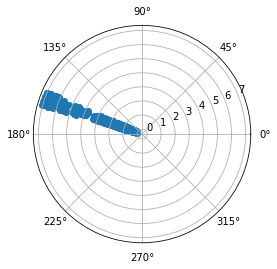

In [14]:
ax = plt.subplot(111, polar=True)
ax.scatter(x=np.deg2rad(data["ra"]), y=data["Spec_redshift"])

<AxesSubplot:xlabel='Spec_redshift', ylabel='Count'>

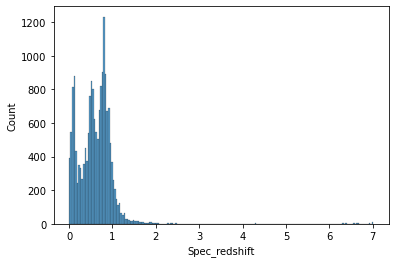

In [15]:
sns.histplot(data, x="Spec_redshift")

## Distance ladder
Equation (4.2.2) of Coles & Lucchin (p.77) comes essentially from the Hubble law
$$
d \simeq \frac{c}{H_0}z \simeq 3000h^{-1} z \,\, \text{Mpc}
$$

Some comments about its validity:

* d must be sufficiently large that the recession velocity $v = H_0 d$ is much larger than the peculiar velocity of the object. In terms of redshift, this means $z \gg 10^{-2}$
* The velocity must not be so large that v is greater than the speed of light. Then, $z \ll 10^{-1}$

These conditions together means that $10^{-2} \leq z \leq 10^{-1}$

In a Friedmann model, this result is an approximation. Indeed,
$$
    a(t) = a_0 \left(1 + H_0(t - t_0) - \frac{1}{2}q_0 H_0^2 (t - t_0)^2 + \dots \right)
$$
where $q_0$ is the deceleration parameter
$$
    q_0 = \frac{\ddot{a}(t_0) a_0}{\dot{a}(t_0)^2}
$$

Redshift is defined as 
$$
    1 + z = \frac{a_0}{a} = \frac{\lambda_{\text{obs}}}{\lambda_{\text{source}}}
$$
this means that
$$
    z = H_0 (t_0 - t) + \left(1 + \frac{1}{2}q_0\right)H_0^2(t_0 - t)^2 + \dots 
$$

To find the distance $r$, we need to use the FRW metric,
$$
    \int_t^{t_0} \frac{c dt}{a} = \int_0^r \frac{dr}{(1 - \kappa r^2)^{1/2}} 
$$

Therefore
$$
    \frac{c}{a_0} \int_t^{t_0} [1 + H_0 (t_0 - t) + \left(1 + \frac{1}{2}q_0\right)H_0^2(t_0 - t)^2 + \dots ] \simeq r + \mathcal{O}(r^3)
$$
The distance can therefore be expressed in term of the redshift
$$
    r = \frac{c}{a_0H_0}[z - \frac{1}{2}(1 + q_0)z^2 + \dots] 
$$
by inverting the series.

The luminosity distance can be derived so that the radiative inverse square law of propagation is respected:
$$
    d_L = a_0^2 \frac{r}{a}
$$
We can therefore show that
$$
    d_L = \frac{c}{H_0} [z + \frac{1}{2}(1 - q_0)z^2 + \dots]
$$

## Preprocessing


In [93]:
_data = data[(data["Spec_redshift"] < 1) & (data["Spec_redshift"] > 0.001)]
# data = data[(data["Photo_redshift"] < 0.9) & (data["Photo_redshift"] > 0.2)]
_data = _data[_data["class"] == "GALAXY"]

In [94]:
H0 = 72 * u.km / u.s / u.Mpc
alpha = (c/H0).to(u.Mpc)

In [95]:
len(_data)

16183

In [96]:
# spherical coordinates
cosmo = FlatLambdaCDM(H0, 0.3)
theta = np.deg2rad(_data["dec"]).to_numpy()
phi = np.deg2rad(_data["ra"]).to_numpy()
# r = alpha * data["Photo_redshift"].to_numpy()
# r = alpha * _data["Spec_redshift"].to_numpy()
r = cosmo.comoving_distance(_data["Spec_redshift"].to_numpy())
#cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

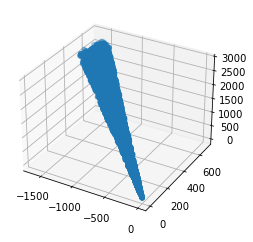

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

(array([ 914., 1726.,  709.,  741., 1038., 1906., 1997., 1992., 3191.,
        1969.]),
 array([   6.21550181,  326.7648595 ,  647.31421719,  967.86357489,
        1288.41293258, 1608.96229027, 1929.51164796, 2250.06100566,
        2570.61036335, 2891.15972104, 3211.70907873]),
 <BarContainer object of 10 artists>)

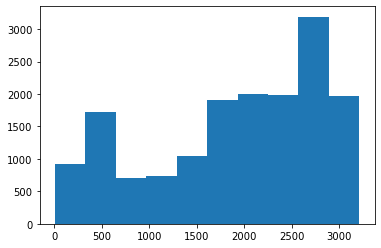

In [98]:
plt.hist(r.value)

## Dataset statistics

We approximate the volume as a cone, therefore
$$
    V \simeq \frac{1}{12}\pi h^3 \tan^2(\bar{\vartheta})
$$
where $h = c \max_{\mathcal{D}}(z) / H_0$ and $\bar{\vartheta}$ is an estimate of the cone opening angle by taking the greatest angle difference in the declination angle or right ascension angle in the dataset.

In [102]:
# We estimate the mean density by approximating the volume as a cone -> this a poisson poit process model estimate of the density
theta_opening = np.max(theta) - np.min(theta)
phi_opening = np.max(phi) - np.min(phi)
opening = max(theta_opening, phi_opening)
V = np.pi * np.max(r)**3 * np.tan(opening)**2 / 12
n = len(_data) / V # mean density
n

<Quantity 9.44774127e-05 1 / Mpc3>

## Autocorrelation function 

The spatial correlation function $\xi(r)$ is a unitless measure of overdensity in regions of characteristic scale $r$ 
$$
    \xi(\mathbf{r}) = \frac{\langle n(\mathbf{r}_1) n(\mathbf{r}_1 + \mathbf{r} )\rangle}{\langle n \rangle ^2} - 1
$$
where $\langle n \rangle$ is the mean density according to some model. In our case, 
$$
    \langle n \rangle = \frac{12 N_{\text{gal}}}{\pi z_\max^3 \tan^2(\theta)}
$$

We create a number density estimator of $n(\mathbf{r})$ by pixelizing the volume survey and counting the number of galazy found in each pixels.
<!-- $$
    P(k) = \int d^3r \xi(r) e^{i \mathbf{k} \cdot \mathbf{r}}
$$ -->

In [103]:
# select a subsample to speed up computation during testing
select = 0.1
indices = np.random.randint(0, len(x), int(select * len(x)))
_x = x[indices].value # remove unit to speed up computation
_y = y[indices].value
_z = z[indices].value
position = np.concatenate([_x[:, np.newaxis], _y[:, np.newaxis], _z[:, np.newaxis]], axis=1)

In [104]:
# generate a cartesian grid in the region of interest
# with want pixel of equal size dispersed in the volume, which is a slice
ell = 15 # Mpc
# start the grid where the opening allows for at least one pixel
radial_grid = np.arange(max(ell/opening, r.min().value), r.max().value, ell)
radial_grid.size

207

In [105]:
theta_min = theta.min()
phi_min = phi.min()
theta_max = theta.max()
phi_max = phi.max()

theta_grids = []
phi_grids = []
for _r in radial_grid:
    # avoid placing pixel at the edges, this means shifting the angle array by ell/r/2
    theta_grids.append(list(np.arange(theta_min + ell/_r/2, theta_max, ell/_r)))
    phi_grids.append(list(np.arange(phi_min + ell/_r/2, phi_max, ell/_r)))
    

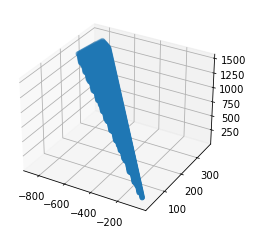

In [48]:
# create the pixel coordinate array
temp = list(zip(list(radial_grid), theta_grids, phi_grids)) # attach theta_grid to its respective radius
coords = []
for r_list in temp:
    _r = r_list[0]
    _theta_list = r_list[1]
    _phi_list = r_list[2]
    coords.extend([(_r, _theta, _phi) for _theta in _theta_list for _phi in _phi_list])
def spherical_to_cartesian(coords):
    r = coords[:, 0]
    theta = coords[:, 1]
    phi = coords[:, 2]
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.column_stack([x, y, z])

pixel_grid = np.vstack(coords)
pixel_grid = spherical_to_cartesian(pixel_grid)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pixel_grid[:, 0], pixel_grid[:, 1], pixel_grid[:, 2])

In [49]:
def voxel_count(r, r_i, ell):
    # r: position of the marks (galaxies)
    # r_i: position of the center of each pixel
    # 6 condition for a voxel
    right_condition =  r[np.newaxis, :, 0] < r_i[:, np.newaxis, 0] + ell/2
    left_condition = r[np.newaxis, :, 0] > r_i[:, np.newaxis, 0] - ell/2
    up_condition = r[np.newaxis, :, 1] < r_i[:, np.newaxis, 1] + ell/2
    down_condition = r[np.newaxis, :, 1] > r_i[:, np.newaxis, 1] - ell/2
    front_condition = r[np.newaxis, :, 2] < r_i[:, np.newaxis, 2] + ell/2
    back_condition = r[np.newaxis, :, 2] > r_i[:, np.newaxis, 2] - ell/2
    return (right_condition * left_condition * up_condition * down_condition * front_condition * back_condition).sum(axis=1)

pixel_count_estimator = voxel_count(position, pixel_grid, ell)
N_pixel = pixel_count_estimator.size
pair_pixel_product = np.zeros(N_pixel * (N_pixel  - 1)//2)
pair_distance = np.zeros(N_pixel  * (N_pixel  - 1)//2)


k = 0
for i in range(N_pixel):
    for j in range(i + 1, N_pixel):
        pair_pixel_product[k] = pixel_count_estimator[i] * pixel_count_estimator[j]
        d = pixel_grid[i] - pixel_grid[j]
        pair_distance[k] = np.sqrt(d.T @ d)
        k += 1

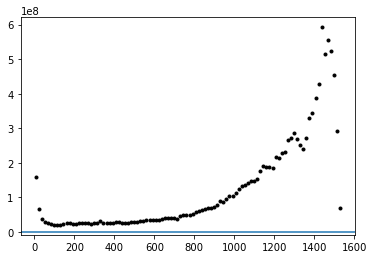

In [52]:
# normalization = pixel_count_estimator.mean()
correlation_estimator, bin_edge, bin_number = binned_statistic(x=pair_distance, values=pair_pixel_product, bins=100)
normalization = len(_data) / V.value #* bin_edge[1:]**3 # normalization depends on r!

plt.plot(bin_edge[:-1], correlation_estimator/normalization**2, ".k")
# plt.yscale("log")
# plt.ylim(None, 2)
# plt.xscale("log")
plt.axhline(0)

In [39]:
# (correlation_estimator/normalization**2).min()
# correlation_estimator/normalization**
normalization

array([1.56502302e-01, 2.89589967e+00, 1.23559186e+01, 3.27162751e+01,
       6.81566853e+01, 1.22856865e+02, 2.00996531e+02, 3.06755398e+02,
       4.44313184e+02, 6.17849603e+02, 8.31544372e+02, 1.08957721e+03,
       1.39612782e+03, 1.75537594e+03, 2.17150127e+03, 2.64868353e+03,
       3.19110244e+03, 3.80293770e+03, 4.48836905e+03, 5.25157619e+03,
       6.09673884e+03, 7.02803672e+03, 8.04964954e+03, 9.16575702e+03,
       1.03805389e+04, 1.16981748e+04, 1.31228446e+04, 1.46587279e+04,
       1.63100044e+04, 1.80808538e+04, 1.99754560e+04, 2.19979905e+04,
       2.41526371e+04, 2.64435756e+04, 2.88749856e+04, 3.14510468e+04,
       3.41759390e+04, 3.70538419e+04, 4.00889352e+04, 4.32853986e+04,
       4.66474118e+04, 5.01791546e+04, 5.38848066e+04, 5.77685477e+04,
       6.18345574e+04, 6.60870155e+04, 7.05301018e+04, 7.51679959e+04,
       8.00048775e+04, 8.50449265e+04, 9.02923224e+04, 9.57512451e+04,
       1.01425874e+05, 1.07320389e+05, 1.13438970e+05, 1.19785797e+05,
      

In [507]:
# stats.describe(pairs) 

In [506]:
# plt.hist(pairs, bins=50)
# plt.xlabel("Distance (Mpc)")

# Power spectrum of the data

This is not a measure of correlation

In [240]:
# make a k-space grid. The complexity of the fourier transform is size(k-space) * size(real-space)
len(_data)

4818

In [241]:
N_k = 10000
k = np.logspace(-4, 1, int(N_k**(1/3)))
k_xx, k_yy, k_zz = np.meshgrid(k, k, k)
k_space = np.column_stack([k_xx.flatten(), k_yy.flatten(), k_zz.flatten()])

In [242]:
# fourier transform of the data
delta_k = np.exp(1j * np.einsum("ij, kj -> ik", k_space, position)).mean(axis=1)

In [266]:
# to get the power spectra, we sum the delta over k-shells
k_mag = np.einsum("ij, ij -> i", k_space, k_space)**(1/2)
delta_shell = 0.0001
# k_shell = np.arange(0.0001, 1, delta_shell)
k_shell = np.logspace(-4, 1, 10_000)
power_spectra = np.zeros(k_shell.size, dtype=np.complex)
shell_index = np.zeros(k_mag.size)
for i, shell in enumerate(k_shell[:-1]):
    V_shell = 0.5 * np.pi * shell**2 * k_shell[i + 1] # we are sampling 1/8 of the sphere
    selection = (k_mag >= shell) & (k_mag < shell + k_shell[i + 1])
    power_spectra[i] = delta_k[selection].sum() / V_shell
    shell_index[selection] = i

Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

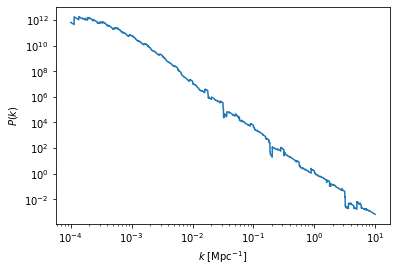

In [354]:
# remove the artificial zeros in the power spectra
valid = np.abs(power_spectra) != 0
k_valid = k_shell[valid]
p = np.abs(power_spectra)[valid]
plt.plot(k_shell[valid], np.abs(power_spectra)[valid])
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$P(k)$")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")

In [355]:
def power_spectrum_model(k, A, lambda_0, n):
    return A * k**n #* np.exp(- lambda_0 * k)

def log_likelihood(x):
    p_hat = power_spectrum_model(k_valid, *x)
    return np.mean((p_hat - p)**2 / 0.01 / p**2)

guess = [1000, 200, 0]

bounds = [(0.01, 1000), (-0.001, 500), (-3, 2)]
opt = minimize(log_likelihood, method="L-BFGS-B", x0=guess, bounds=bounds)

In [356]:
opt

      fun: 79.09767365234435
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.84217094e-06, 0.00000000e+00, 4.10150323e+01])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 44
      nit: 3
     njev: 11
   status: 0
  success: True
        x: array([  0.31057318, 200.        ,  -3.        ])

In [341]:
power_spectrum_model(k_valid, *opt.x).min()

0.0

# Count in sphere

In [ ]:
# random catalogue
N_u = 1000